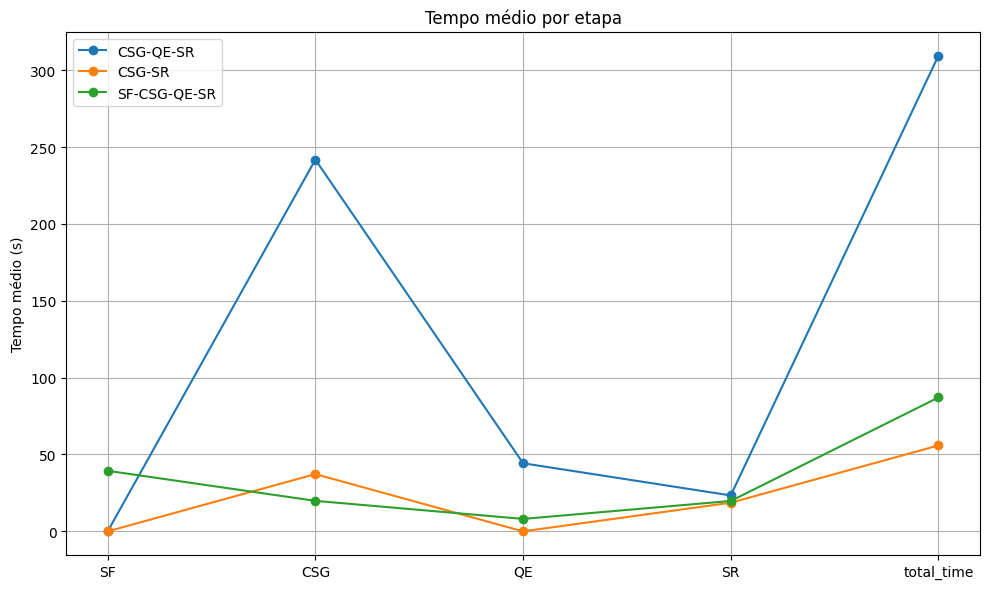

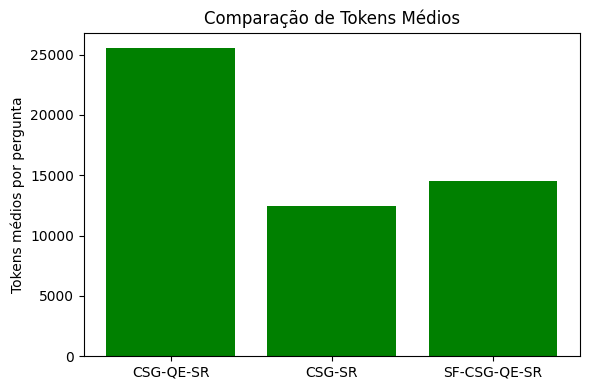

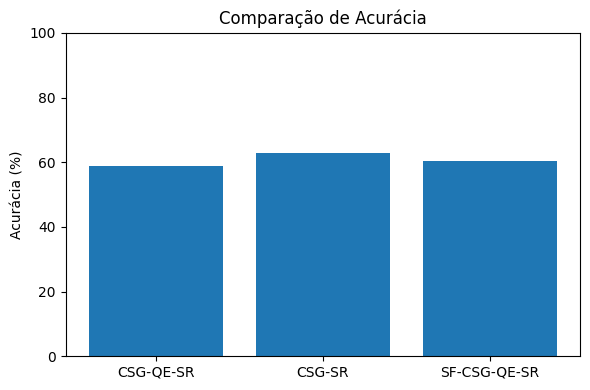

In [1]:
import json
import os
import matplotlib.pyplot as plt
import glob


def coletar_dados(caminho_arquivo):
    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        dados = json.load(f)

    etapas = ["SF", "CSG", "QE", "SR"]
    tempo_total = {etapa: 0.0 for etapa in etapas}
    tempo_total["total_time"] = 0.0
    total_tokens = 0
    total_perguntas = 0
    total_acertos = 0

    for item in dados:
        total_perguntas += 1

        # Tempo
        timing = item.get("timing", {})
        for etapa in etapas:
            tempo_total[etapa] += timing.get(etapa, 0.0)
        tempo_total["total_time"] += timing.get("total_time", 0.0)

        # Tokens
        total_tokens += item.get("total_usage", {}).get("total_tokens", 0)

        # Acurácia
        if item.get("results", {}).get("exec_res", 0) == 1:
            total_acertos += 1

    medias_tempo = {etapa: tempo_total[etapa] / total_perguntas for etapa in tempo_total}
    media_tokens = total_tokens / total_perguntas
    acuracia = (total_acertos / total_perguntas) * 100

    return medias_tempo, media_tokens, acuracia, total_perguntas, total_acertos


# Busca automaticamente os arquivos predictions.json dentro da pasta results
arquivos_encontrados = glob.glob("results/**/predictions.json", recursive=True)

# Cria dicionário com nome da pasta final como chave e caminho como valor
arquivos = {}
for caminho in arquivos_encontrados:
    nome_modelo = os.path.basename(os.path.dirname(caminho))  # Pega o nome da pasta (ex: model_outputs_dev_CSG-SR...)
    nome_modelo = nome_modelo.replace("model_outputs_dev_", "").replace("_gpt-4.1-mini", "")
    arquivos[nome_modelo] = caminho

tempos_por_modelo = {}
tokens_por_modelo = {}
acuracias_por_modelo = {}
total_perguntas = {}
total_acertos = {}


for nome_modelo, caminho in arquivos.items():
    medias_tempo, media_tokens, acuracia, num_perguntas, num_acertos = coletar_dados(caminho)
    tempos_por_modelo[nome_modelo] = medias_tempo
    tokens_por_modelo[nome_modelo] = media_tokens
    acuracias_por_modelo[nome_modelo] = acuracia
    total_perguntas[nome_modelo] = num_perguntas
    total_acertos[nome_modelo] = num_acertos


# Gráfico 1: Tempo médio por etapa
etapas = ["SF", "CSG", "QE", "SR", "total_time"]
x = range(len(etapas))

plt.figure(figsize=(10, 6))
for nome_modelo in arquivos:
    y = [tempos_por_modelo[nome_modelo].get(etapa, 0.0) for etapa in etapas]
    plt.plot(x, y, marker='o', label=nome_modelo)
plt.xticks(x, etapas)
plt.ylabel("Tempo médio (s)")
plt.title("Tempo médio por etapa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Média de tokens
plt.figure(figsize=(6, 4))
plt.bar(tokens_por_modelo.keys(), tokens_por_modelo.values(),color='g')
plt.ylabel("Tokens médios por pergunta")
plt.title("Comparação de Tokens Médios")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(acuracias_por_modelo.keys(), acuracias_por_modelo.values())
plt.ylabel("Acurácia (%)")
plt.title("Comparação de Acurácia")
plt.ylim(0, 100)  # Aqui você define o limite do eixo Y
plt.tight_layout()
plt.show()


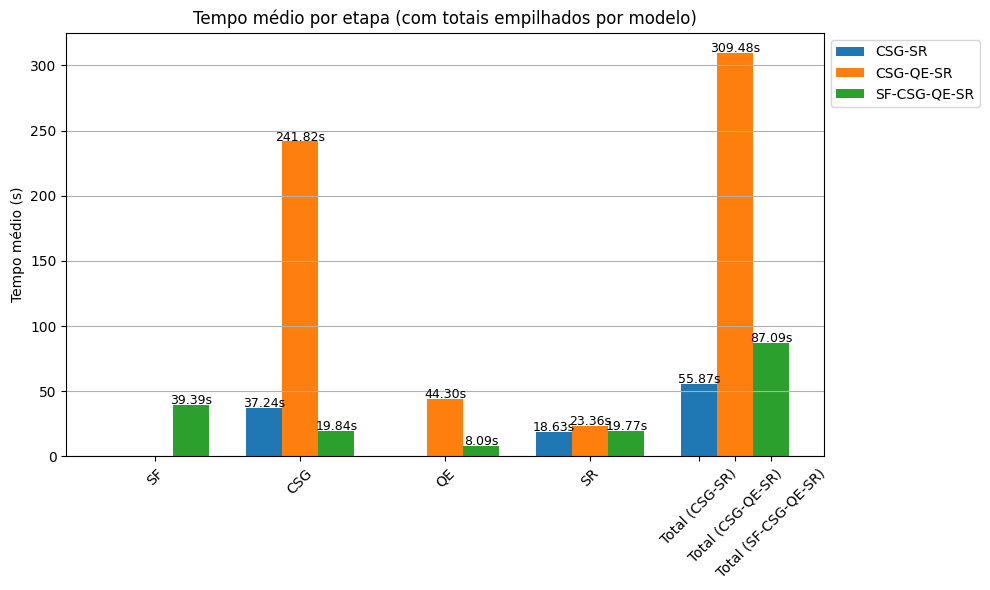

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Etapas e ordem desejada dos modelos
etapas_simples = ["SF", "CSG", "QE", "SR"]
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
x = np.arange(len(etapas_simples))  # Posições X para etapas simples
largura = 0.25

# Cores fixas por modelo
cores_modelos = {
    "CSG-SR": "#1f77b4",       # azul
    "CSG-QE-SR": "#ff7f0e",    # laranja
    "SF-CSG-QE-SR": "#2ca02c"  # verde
}

plt.figure(figsize=(10, 6))

# Barras agrupadas por etapa simples + rótulos
for i, nome_modelo in enumerate(modelos):
    y = [tempos_por_modelo[nome_modelo].get(etapa, 0.0) for etapa in etapas_simples]
    posicoes = x + i * largura
    plt.bar(posicoes, y, width=largura, label=nome_modelo, color=cores_modelos[nome_modelo])
    
    for xi, yi in zip(posicoes, y):
        if yi > 0:
            plt.text(xi, yi + 0.5, f"{yi:.2f}s", ha='center', fontsize=9)

# Barras empilhadas (um stack por modelo) + rótulo SOMENTE da soma
x_empilhadas = [len(etapas_simples) + i * largura for i in range(len(modelos))]
bases = [0] * len(modelos)

for etapa in etapas_simples:
    alturas = [tempos_por_modelo[modelo].get(etapa, 0.0) for modelo in modelos]
    for j, modelo in enumerate(modelos):
        y_base = bases[j]
        y_altura = alturas[j]
        x_pos = x_empilhadas[j]
        
        plt.bar(x_pos, y_altura, bottom=y_base, width=largura, color=cores_modelos[modelo])
        bases[j] += y_altura

# Texto total no topo da barra empilhada
for j, modelo in enumerate(modelos):
    total = bases[j]
    if total > 0:
        plt.text(x_empilhadas[j], total + 0.5, f"{total:.2f}s", ha='center', fontsize=9, color='black')

# Eixos e labels
ticks_x = list(x + largura) + x_empilhadas
ticks_labels = etapas_simples + [f"Total ({modelo})" for modelo in modelos]

plt.xticks(ticks_x, ticks_labels, rotation=45)
plt.ylabel("Tempo médio (s)")
plt.title("Tempo médio por etapa (com totais empilhados por modelo)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


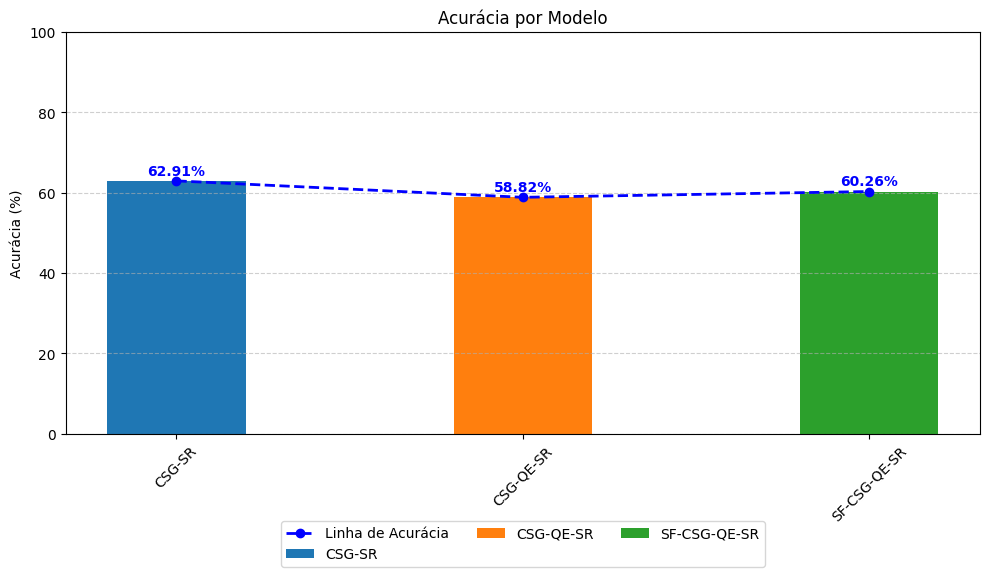

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Ordem fixa dos modelos
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
acuracias = [acuracias_por_modelo[m] for m in modelos]

x = np.arange(len(modelos))
largura = 0.4

# Cores por modelo
cores_modelos = {
    "CSG-SR": "#1f77b4",
    "CSG-QE-SR": "#ff7f0e",
    "SF-CSG-QE-SR": "#2ca02c"
}

# Plot
plt.figure(figsize=(10, 6))

# Barras por modelo
for i, modelo in enumerate(modelos):
    plt.bar(x[i], acuracias[i], width=largura, color=cores_modelos[modelo], label=modelo)
    plt.text(x[i], acuracias[i] + 1.5, f"{acuracias[i]:.2f}%", ha='center', fontsize=10, color='blue', weight='bold')

# Linha de acurácia
plt.plot(x, acuracias, color='blue', linestyle='--', marker='o', linewidth=2, label="Linha de Acurácia")

# Estilo
plt.ylim(0, 100)
plt.xticks(x, modelos, rotation=45)
plt.ylabel("Acurácia (%)")
plt.title("Acurácia por Modelo")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.tight_layout()
plt.show()


<class 'dict'> {'CSG-QE-SR': 90, 'CSG-SR': 95, 'SF-CSG-QE-SR': 91}
<class 'dict'> {'CSG-QE-SR': 153, 'CSG-SR': 151, 'SF-CSG-QE-SR': 151}


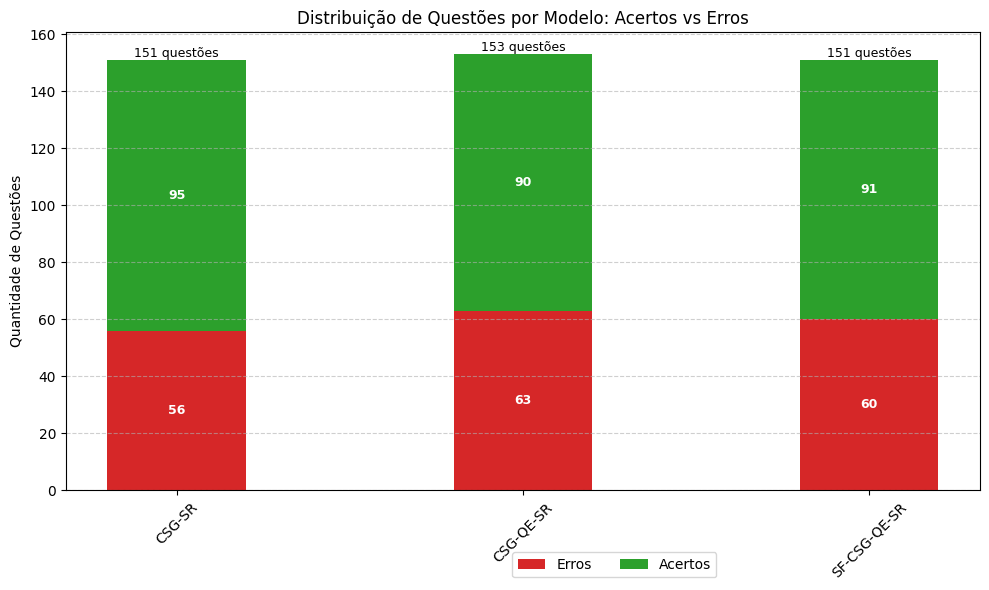

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Ordem desejada
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
print(type(total_acertos), total_acertos)
print(type(total_perguntas), total_perguntas)

# Dados assumidos já carregados: total_acertos, total_perguntas
acertos = [total_acertos[m] for m in modelos]
totais = [total_perguntas[m] for m in modelos]
erros = [totais[i] - acertos[i] for i in range(len(modelos))]

x = np.arange(len(modelos))
largura = 0.4

# Cores
cor_acertos = "#2ca02c"
cor_erros = "#d62728"

# Plot
plt.figure(figsize=(10, 6))

# Barras empilhadas
plt.bar(x, erros, width=largura, color=cor_erros, label="Erros")
plt.bar(x, acertos, width=largura, bottom=erros, color=cor_acertos, label="Acertos")

# Anotações
for i in range(len(modelos)):
    plt.text(x[i], erros[i] / 2, f"{erros[i]}", ha='center', va='center', fontsize=9, color='white', weight='bold')
    plt.text(x[i], erros[i] + acertos[i] / 2, f"{acertos[i]}", ha='center', va='center', fontsize=9, color='white', weight='bold')
    plt.text(x[i], erros[i] + acertos[i] + 1, f"{totais[i]} questões", ha='center', fontsize=9, color='black')

# Estilo
plt.xticks(x, modelos, rotation=45)
plt.ylabel("Quantidade de Questões")
plt.title("Distribuição de Questões por Modelo: Acertos vs Erros")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.6, -0.12), ncol=2)

plt.tight_layout()
plt.show()


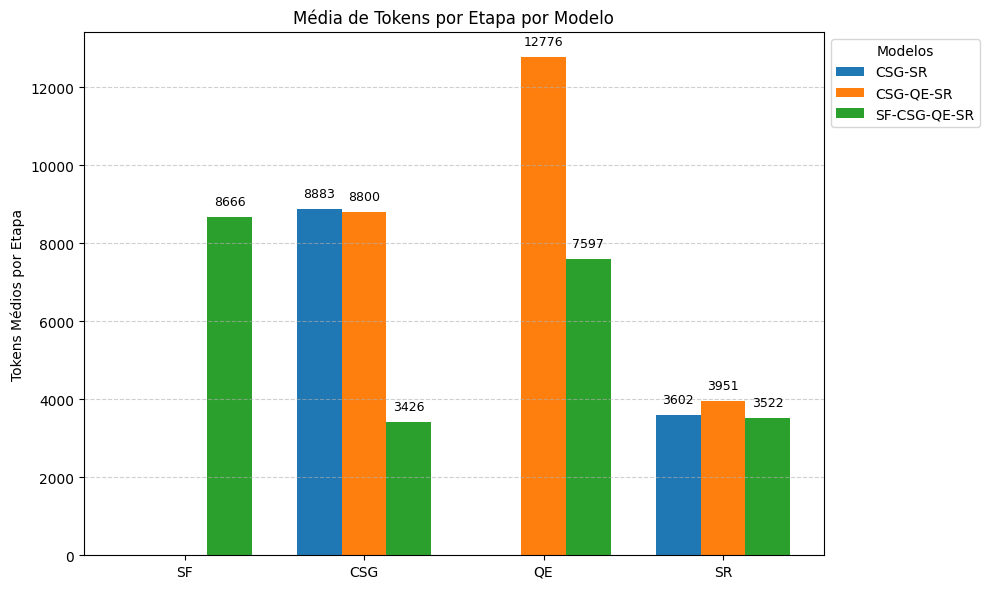

In [5]:
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# Etapas e correspondência com os campos do JSON
etapas = {
  "SF": "schema_filtering",
  "CSG": "candidate_sql_generation",
  "QE": "question_enrichment",
  "SR": "sql_refinement"
}

# Ordem desejada dos modelos
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
cores_modelos = {
    "CSG-SR": "#1f77b4",
    "CSG-QE-SR": "#ff7f0e",
    "SF-CSG-QE-SR": "#2ca02c"
}

# Encontra todos os predictions.json
predictions_files = glob.glob("results/**/predictions.json", recursive=True)

# Armazena: modelo -> etapa -> média de tokens
medias_por_modelo = {}

for caminho in predictions_files:
    pasta = os.path.basename(os.path.dirname(caminho))
    nome_modelo = pasta.replace("model_outputs_dev_", "").replace("_gpt-4.1-mini", "")

    if nome_modelo not in modelos:
        continue  # ignora modelos fora da ordem desejada

    with open(caminho, 'r', encoding='utf-8') as f:
        dados = json.load(f)

    soma_tokens = {etapa: 0 for etapa in etapas}
    contagem_tokens = {etapa: 0 for etapa in etapas}

    for item in dados:
        for etapa, campo_json in etapas.items():
            if campo_json in item and isinstance(item[campo_json], dict):
                total_tokens = item[campo_json].get("total_tokens", 0)
                soma_tokens[etapa] += total_tokens
                contagem_tokens[etapa] += 1

    medias = {
        etapa: soma_tokens[etapa] / contagem_tokens[etapa] if contagem_tokens[etapa] > 0 else 0
        for etapa in etapas
    }
    medias_por_modelo[nome_modelo] = medias

# Gráfico de barras agrupadas por etapa
etapas_ordem = list(etapas.keys())
x = np.arange(len(etapas_ordem))
largura = 0.25  # ajustado para 3 modelos

plt.figure(figsize=(10, 6))

# Plotar barras com valores no topo
for i, modelo in enumerate(modelos):
    y = [medias_por_modelo[modelo][etapa] for etapa in etapas_ordem]
    deslocamento = (i - len(modelos)/2) * largura + largura/2
    posicoes = x + deslocamento
    plt.bar(posicoes, y, width=largura, label=modelo, color=cores_modelos[modelo])

    # Rótulos no topo
    for xi, yi in zip(posicoes, y):
        if yi > 0:
            plt.text(xi, yi + 300, f"{yi:.0f}", ha="center", fontsize=9)

# Estilo final
plt.xticks(x, etapas_ordem)
plt.ylabel("Tokens Médios por Etapa")
plt.title("Média de Tokens por Etapa por Modelo")
plt.legend(title="Modelos", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


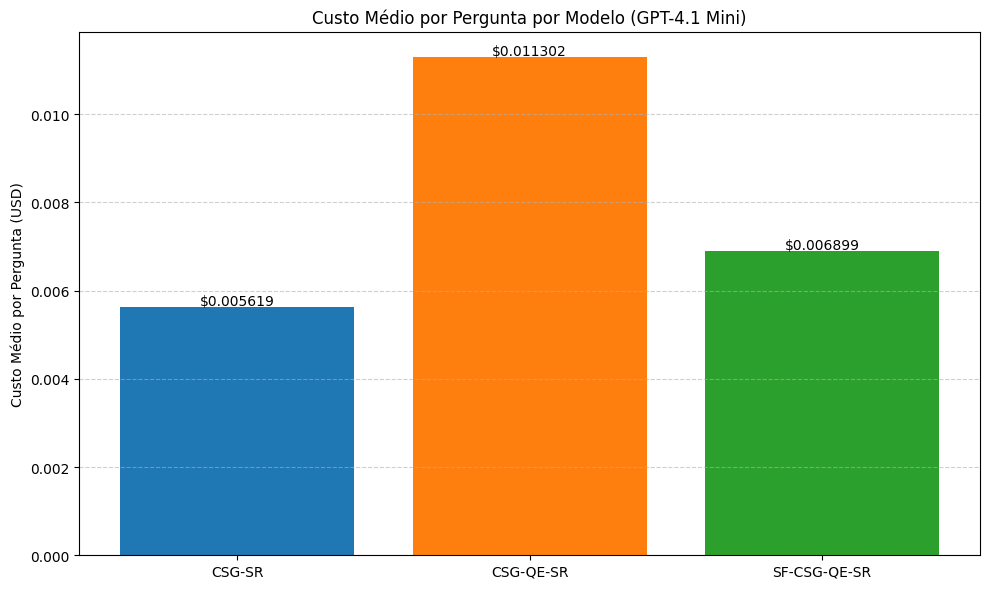

In [6]:
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# Preços por milhão de tokens
preco_input = 0.40
preco_output = 1.60

# Ordem e cores fixas dos modelos
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
cores_modelos = {
    "CSG-SR": "#1f77b4",
    "CSG-QE-SR": "#ff7f0e",
    "SF-CSG-QE-SR": "#2ca02c"
}

# Coleta de dados
predictions_files = glob.glob("results/**/predictions.json", recursive=True)

custo_medio_por_modelo = {}

for caminho in predictions_files:
    with open(caminho, 'r', encoding='utf-8') as f:
        dados = json.load(f)

    total_custo = 0
    total_perguntas = 0

    for item in dados:
        uso = item.get("total_usage", {})
        prompt = uso.get("prompt_tokens", 0)
        completion = uso.get("completion_tokens", 0)

        custo = (prompt * preco_input + completion * preco_output) / 1_000_000
        total_custo += custo
        total_perguntas += 1

    if total_perguntas > 0:
        nome_modelo = os.path.basename(os.path.dirname(caminho)).replace("model_outputs_dev_", "").replace("_gpt-4.1-mini", "")
        if nome_modelo in modelos:
            custo_medio_por_modelo[nome_modelo] = total_custo / total_perguntas

# Prepara os dados ordenados
custos = [custo_medio_por_modelo.get(m, 0) for m in modelos]

# Plotar gráfico
x = np.arange(len(modelos))
plt.figure(figsize=(10, 6))
plt.bar(x, custos, color=[cores_modelos[m] for m in modelos])

# Anotar valores em cima das barras
for i, valor in enumerate(custos):
    plt.text(i, valor + 0.00005, f"${valor:.6f}", ha='center', fontsize=10)

plt.xticks(x, modelos)
plt.ylabel("Custo Médio por Pergunta (USD)")
plt.title("Custo Médio por Pergunta por Modelo (GPT-4.1 Mini)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


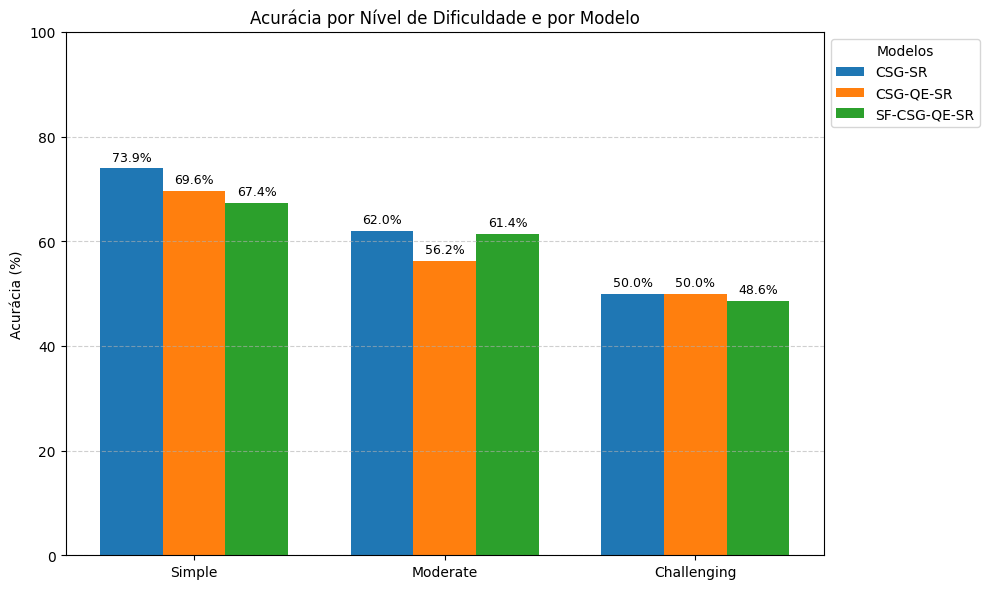

In [7]:
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# Modelos e cores
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
cores_modelos = {
    "CSG-SR": "#1f77b4",
    "CSG-QE-SR": "#ff7f0e",
    "SF-CSG-QE-SR": "#2ca02c"
}

# Dificuldades
dificuldades = ["simple", "moderate", "challenging"]

# Inicializa estrutura: modelo -> dificuldade -> acurácia
acuracia_dificuldade = {modelo: {} for modelo in modelos}

# Encontra arquivos metrics.json
metrics_files = glob.glob("results/**/metrics.json", recursive=True)

for caminho in metrics_files:
    with open(caminho, "r", encoding="utf-8") as f:
        metrics = json.load(f)

    pasta = os.path.basename(os.path.dirname(caminho))
    nome_modelo = pasta.replace("model_outputs_dev_", "").replace("_gpt-4.1-mini", "")
    
    if nome_modelo not in modelos:
        continue

    for nivel in dificuldades:
        stats = metrics.get(f"{nivel}_stats", {})
        count = stats.get("count", 0)
        correct = stats.get("correct_number", 0)
        acuracia = (correct / count * 100) if count > 0 else 0
        acuracia_dificuldade[nome_modelo][nivel] = acuracia

# Plotando gráfico
x = np.arange(len(dificuldades))  # Simple, Moderate, Challenging
largura = 0.25

plt.figure(figsize=(10, 6))

for i, modelo in enumerate(modelos):
    y = [acuracia_dificuldade[modelo].get(nivel, 0) for nivel in dificuldades]
    pos = x + (i - 1) * largura  # centraliza
    plt.bar(pos, y, width=largura, color=cores_modelos[modelo], label=modelo)
    
    # Rótulos de valor
    for xi, yi in zip(pos, y):
        if yi > 0:
            plt.text(xi, yi + 1.5, f"{yi:.1f}%", ha="center", fontsize=9)

# Estilo
plt.xticks(x, [nivel.capitalize() for nivel in dificuldades])
plt.ylabel("Acurácia (%)")
plt.title("Acurácia por Nível de Dificuldade e por Modelo")
plt.ylim(0, 100)
plt.legend(title="Modelos", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


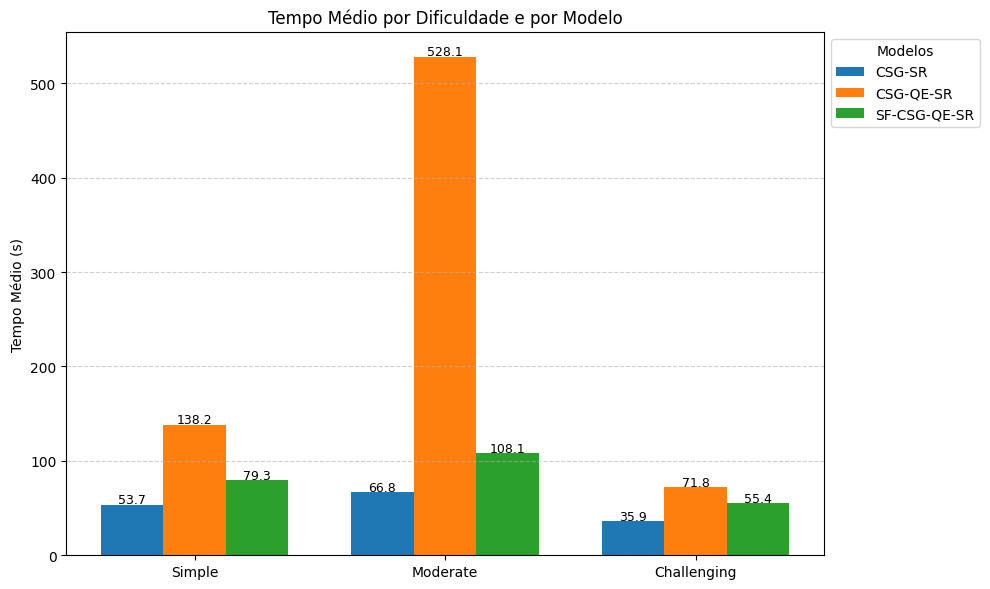

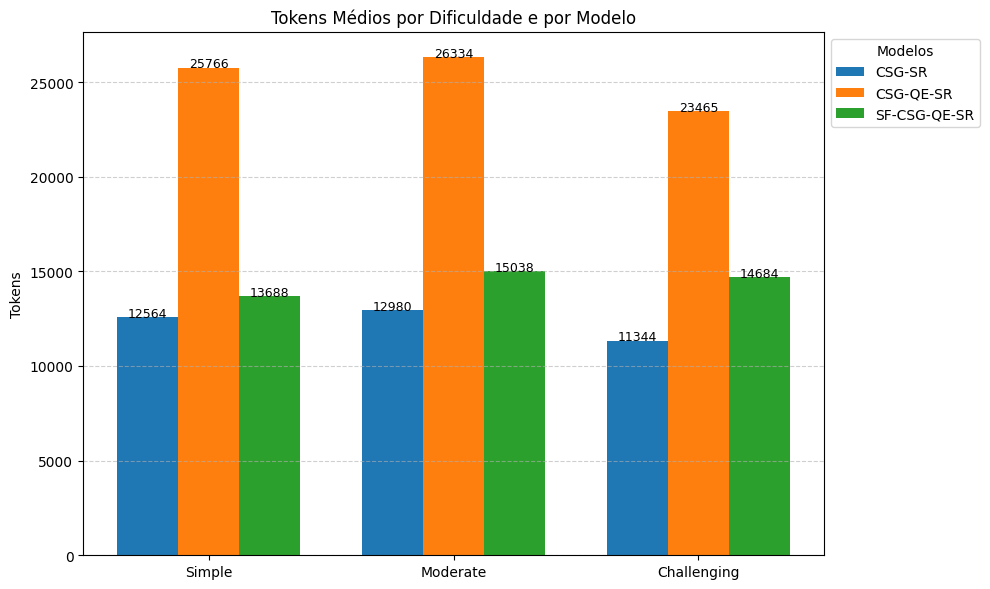

In [8]:
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# Modelos e cores
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
cores_modelos = {
    "CSG-SR": "#1f77b4",
    "CSG-QE-SR": "#ff7f0e",
    "SF-CSG-QE-SR": "#2ca02c"
}

dificuldades = ["simple", "moderate", "challenging"]

# Inicializa estrutura de dados
tempos = {modelo: {dif: [] for dif in dificuldades} for modelo in modelos}
tokens = {modelo: {dif: [] for dif in dificuldades} for modelo in modelos}

# Carrega predictions
predictions_files = glob.glob("results/**/predictions.json", recursive=True)

for caminho in predictions_files:
    pasta = os.path.basename(os.path.dirname(caminho))
    nome_modelo = pasta.replace("model_outputs_dev_", "").replace("_gpt-4.1-mini", "")

    if nome_modelo not in modelos:
        continue

    with open(caminho, 'r', encoding='utf-8') as f:
        dados = json.load(f)

    for item in dados:
        dificuldade = item.get("difficulty")
        if dificuldade in dificuldades:
            tempo = item.get("timing", {}).get("total_time", 0)
            token = item.get("total_usage", {}).get("total_tokens", 0)
            tempos[nome_modelo][dificuldade].append(tempo)
            tokens[nome_modelo][dificuldade].append(token)

# Função para calcular médias e gerar gráfico
def plot_media_por_dificuldade(data_dict, ylabel, title):
    x = np.arange(len(dificuldades))
    largura = 0.25

    plt.figure(figsize=(10, 6))

    for i, modelo in enumerate(modelos):
        y = [
            np.mean(data_dict[modelo][dif]) if data_dict[modelo][dif] else 0
            for dif in dificuldades
        ]
        pos = x + (i - 1) * largura
        plt.bar(pos, y, width=largura, color=cores_modelos[modelo], label=modelo)

        for xi, yi in zip(pos, y):
            if yi > 0:
                label = f"{yi:.1f}" if ylabel != "Tokens" else f"{int(yi)}"
                plt.text(xi, yi + 1.5, label, ha="center", fontsize=9)

    plt.xticks(x, [d.capitalize() for d in dificuldades])
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(title="Modelos", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Gráficos
plot_media_por_dificuldade(tempos, "Tempo Médio (s)", "Tempo Médio por Dificuldade e por Modelo")
plot_media_por_dificuldade(tokens, "Tokens", "Tokens Médios por Dificuldade e por Modelo")


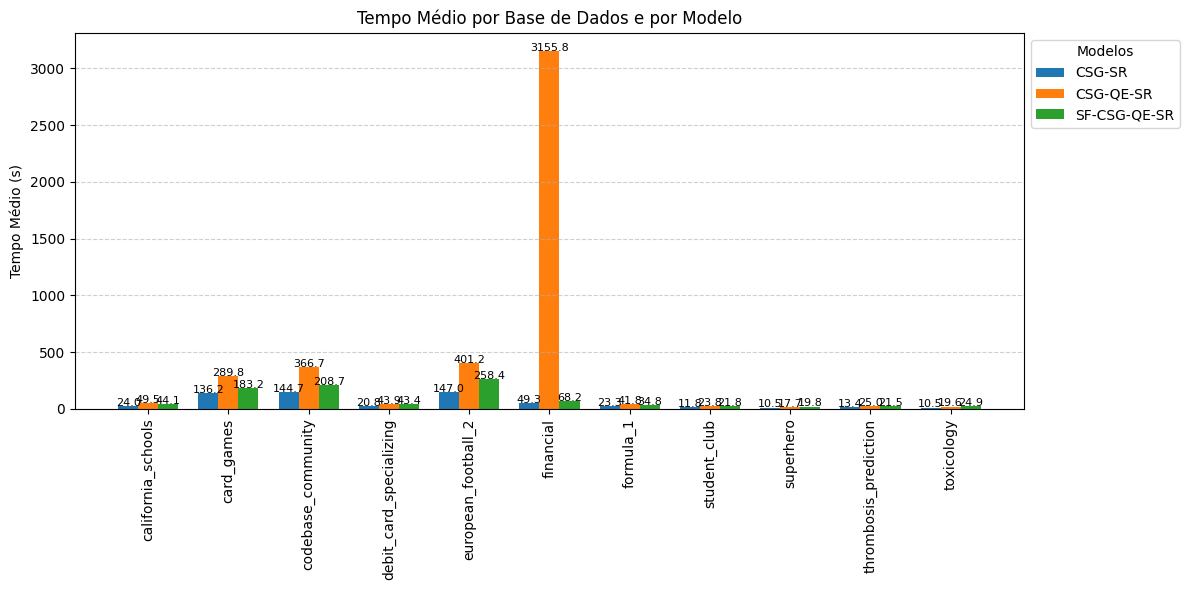

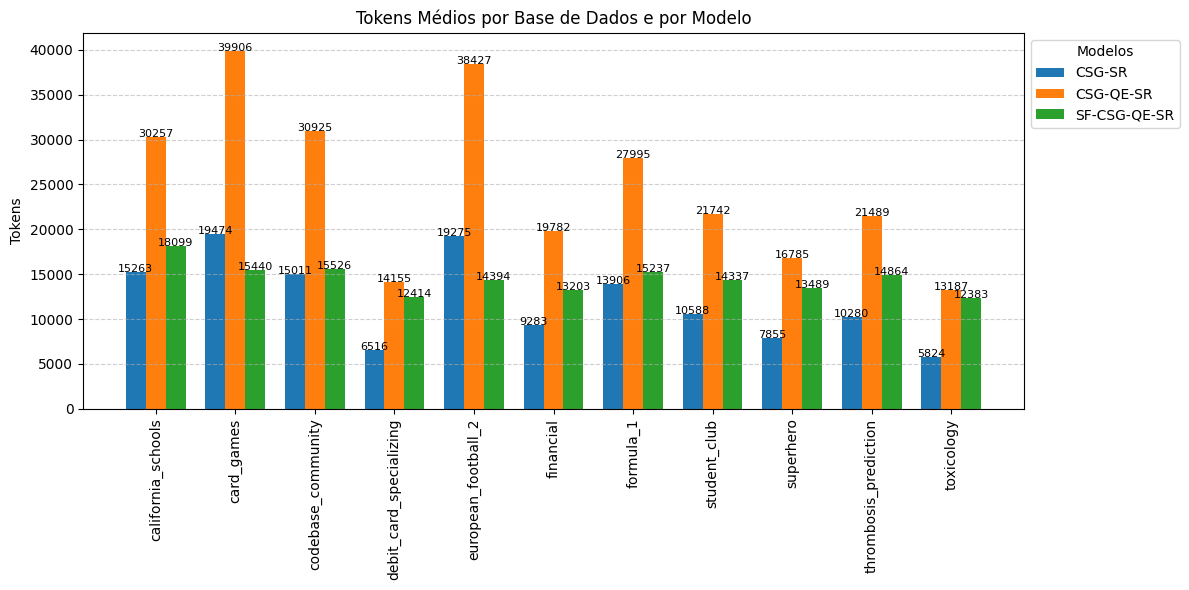

In [9]:
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Modelos e cores
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
cores_modelos = {
    "CSG-SR": "#1f77b4",
    "CSG-QE-SR": "#ff7f0e",
    "SF-CSG-QE-SR": "#2ca02c"
}

# Inicializa estrutura: modelo -> db_id -> [valores...]
tempos_por_db = {modelo: defaultdict(list) for modelo in modelos}
tokens_por_db = {modelo: defaultdict(list) for modelo in modelos}

# Lê os arquivos predictions.json
predictions_files = glob.glob("results/**/predictions.json", recursive=True)

for caminho in predictions_files:
    pasta = os.path.basename(os.path.dirname(caminho))
    nome_modelo = pasta.replace("model_outputs_dev_", "").replace("_gpt-4.1-mini", "")

    if nome_modelo not in modelos:
        continue

    with open(caminho, "r", encoding="utf-8") as f:
        dados = json.load(f)

    for item in dados:
        db = item.get("db_id")
        if not db:
            continue
        tempo = item.get("timing", {}).get("total_time", 0)
        token = item.get("total_usage", {}).get("total_tokens", 0)

        tempos_por_db[nome_modelo][db].append(tempo)
        tokens_por_db[nome_modelo][db].append(token)

# Lista de databases únicas
todas_bases = sorted(set(
    db for modelo in modelos for db in tempos_por_db[modelo]
))

# Função para gerar gráfico por base de dados
def plot_media_por_db(data_dict, ylabel, title):
    x = np.arange(len(todas_bases))
    largura = 0.25

    plt.figure(figsize=(max(12, len(todas_bases) * 0.6), 6))

    for i, modelo in enumerate(modelos):
        y = [
            np.mean(data_dict[modelo][db]) if db in data_dict[modelo] and data_dict[modelo][db] else 0
            for db in todas_bases
        ]
        pos = x + (i - 1) * largura
        plt.bar(pos, y, width=largura, label=modelo, color=cores_modelos[modelo])

        for xi, yi in zip(pos, y):
            if yi > 0:
                label = f"{yi:.1f}" if ylabel != "Tokens" else f"{int(yi)}"
                plt.text(xi, yi + 1.5, label, ha="center", fontsize=8)

    plt.xticks(x, todas_bases, rotation=90)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(title="Modelos", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Gera os dois gráficos
plot_media_por_db(tempos_por_db, "Tempo Médio (s)", "Tempo Médio por Base de Dados e por Modelo")
plot_media_por_db(tokens_por_db, "Tokens", "Tokens Médios por Base de Dados e por Modelo")


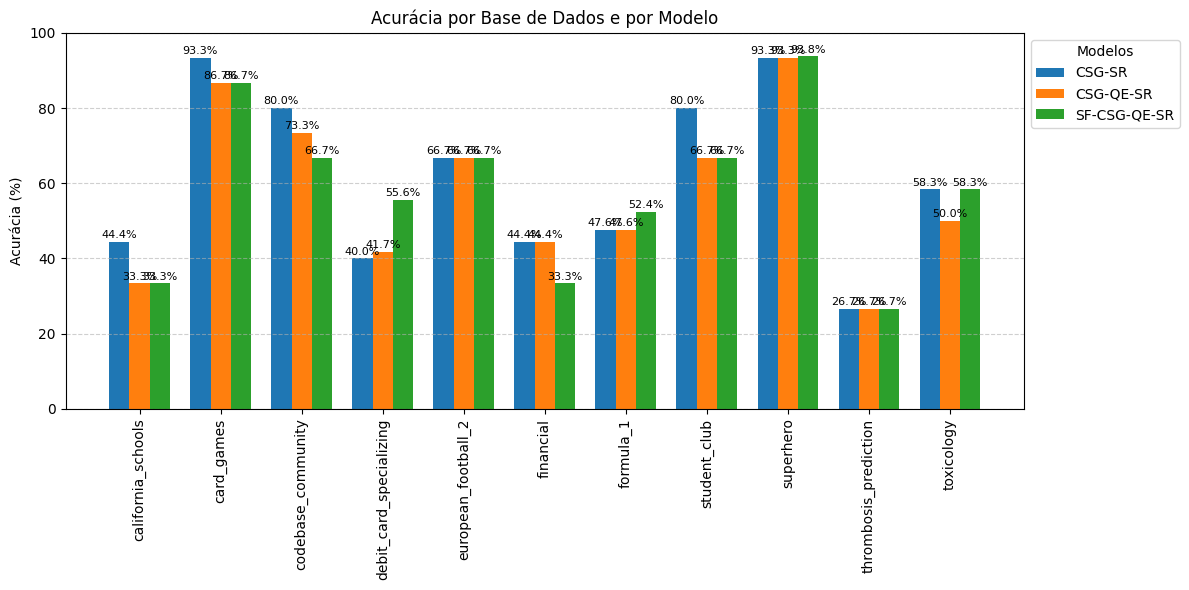

In [10]:
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Modelos e cores
modelos = ["CSG-SR", "CSG-QE-SR", "SF-CSG-QE-SR"]
cores_modelos = {
    "CSG-SR": "#1f77b4",
    "CSG-QE-SR": "#ff7f0e",
    "SF-CSG-QE-SR": "#2ca02c"
}

# Inicializa estrutura: modelo -> db_id -> [resultados]
resultados_por_db = {modelo: defaultdict(list) for modelo in modelos}

# Lê os arquivos predictions.json
predictions_files = glob.glob("results/**/predictions.json", recursive=True)

for caminho in predictions_files:
    pasta = os.path.basename(os.path.dirname(caminho))
    nome_modelo = pasta.replace("model_outputs_dev_", "").replace("_gpt-4.1-mini", "")

    if nome_modelo not in modelos:
        continue

    with open(caminho, "r", encoding="utf-8") as f:
        dados = json.load(f)

    for item in dados:
        db = item.get("db_id")
        if not db:
            continue
        resultado = item.get("results", {}).get("exec_res", 0)
        resultados_por_db[nome_modelo][db].append(int(resultado))

# Lista de databases únicas
todas_bases = sorted(set(
    db for modelo in modelos for db in resultados_por_db[modelo]
))

# Plotar acurácia por base
x = np.arange(len(todas_bases))
largura = 0.25

plt.figure(figsize=(max(12, len(todas_bases) * 0.6), 6))

for i, modelo in enumerate(modelos):
    y = []
    for db in todas_bases:
        resultados = resultados_por_db[modelo].get(db, [])
        if resultados:
            acertos = sum(resultados)
            total = len(resultados)
            acuracia = (acertos / total) * 100
        else:
            acuracia = 0
        y.append(acuracia)
    
    pos = x + (i - 1) * largura
    plt.bar(pos, y, width=largura, color=cores_modelos[modelo], label=modelo)
    
    # Rótulos
    for xi, yi in zip(pos, y):
        if yi > 0:
            plt.text(xi, yi + 1, f"{yi:.1f}%", ha="center", fontsize=8)

# Estilo
plt.xticks(x, todas_bases, rotation=90)
plt.ylabel("Acurácia (%)")
plt.title("Acurácia por Base de Dados e por Modelo")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Modelos", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


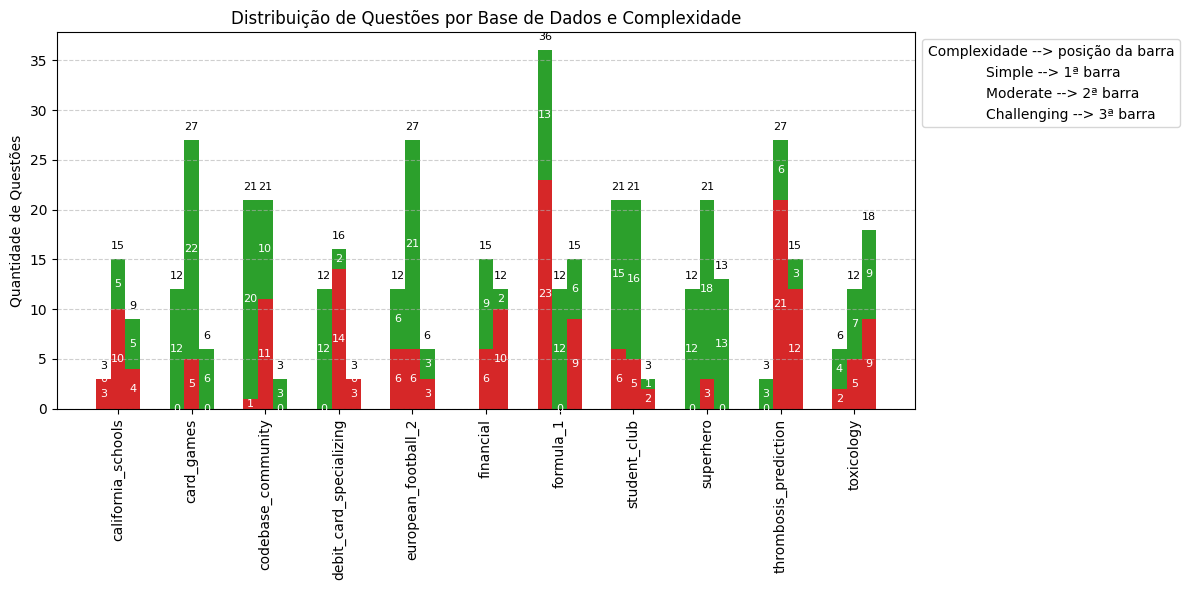

In [11]:
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib.patches import Patch

# Dificuldades e cores
dificuldades = ["simple", "moderate", "challenging"]
cores = {
    "acertos": "#2ca02c",  # verde
    "erros": "#d62728"     # vermelho
}

# Texto da legenda
legenda_dificuldades = [
    "Simple --> 1ª barra",
    "Moderate --> 2ª barra",
    "Challenging --> 3ª barra"
]

# Estrutura: dificuldade -> db_id -> contagem
totais = {dif: defaultdict(int) for dif in dificuldades}
acertos = {dif: defaultdict(int) for dif in dificuldades}

# Coleta dos predictions.json
predictions_files = glob.glob("results/**/predictions.json", recursive=True)

for caminho in predictions_files:
    with open(caminho, "r", encoding="utf-8") as f:
        dados = json.load(f)

    for item in dados:
        db = item.get("db_id")
        dif = item.get("difficulty")
        res = item.get("results", {}).get("exec_res", 0)

        if db and dif in dificuldades:
            totais[dif][db] += 1
            if res == 1:
                acertos[dif][db] += 1

# Todas as bases únicas
dbs = sorted(set(db for dif in dificuldades for db in totais[dif]))

# Dados para gráfico
x = np.arange(len(dbs))
largura = 0.2

plt.figure(figsize=(max(12, len(dbs)*0.6), 6))

for i, dif in enumerate(dificuldades):
    total_q = [totais[dif][db] for db in dbs]
    correct_q = [acertos[dif][db] for db in dbs]
    erro_q = [t - c for t, c in zip(total_q, correct_q)]

    pos = x + (i - 1) * largura
    plt.bar(pos, erro_q, width=largura, color=cores["erros"])
    plt.bar(pos, correct_q, bottom=erro_q, width=largura, color=cores["acertos"])

    # Rótulos
    for xi, c, e in zip(pos, correct_q, erro_q):
        if c + e > 0:
            plt.text(xi, e / 2, f"{e}", ha='center', va='center', color='white', fontsize=8)
            plt.text(xi, e + c / 2, f"{c}", ha='center', va='center', color='white', fontsize=8)
            plt.text(xi, e + c + 1, f"{c + e}", ha='center', fontsize=8, color='black')

# Eixo X
plt.xticks(x, dbs, rotation=90)
plt.ylabel("Quantidade de Questões")
plt.title("Distribuição de Questões por Base de Dados e Complexidade")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Legenda manual (sem cores)
legenda_personalizada = [Patch(color="none", label=txt) for txt in legenda_dificuldades]
plt.legend(handles=legenda_personalizada, title="Complexidade --> posição da barra", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


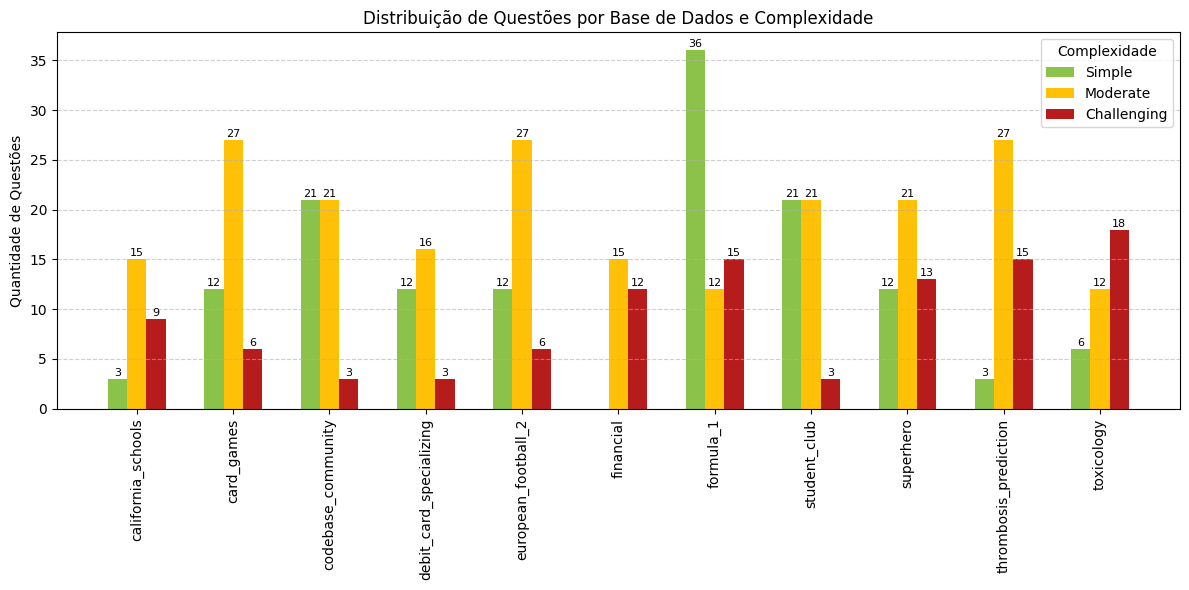

Total de perguntas testadas: 455


In [18]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Dificuldades e cores definidas
dificuldades = ["Simple", "Moderate", "Challenging"]
dificuldades_raw = [d.lower() for d in dificuldades]

cores_dificuldade = {
    "Simple": "#8bc34a",
    "Moderate": "#ffc107",
    "Challenging": "#b71c1c"
}

# Estrutura para contagem: dificuldade -> db_id -> count
totais = {dif: defaultdict(int) for dif in dificuldades_raw}

# Coleta dos predictions.json
predictions_files = glob.glob("results/**/predictions.json", recursive=True)

for caminho in predictions_files:
    with open(caminho, "r", encoding="utf-8") as f:
        dados = json.load(f)

    for item in dados:
        db = item.get("db_id")
        dif = item.get("difficulty")
        if db and dif in dificuldades_raw:
            totais[dif][db] += 1

# Todas as bases únicas
dbs = sorted(set(db for dif in dificuldades_raw for db in totais[dif]))

# Dados para plotagem
x = np.arange(len(dbs))
largura = 0.2

plt.figure(figsize=(max(12, len(dbs) * 0.6), 6))

for i, dif_cap in enumerate(dificuldades):
    dif = dif_cap.lower()
    counts = [totais[dif][db] for db in dbs]
    pos = x + (i - 1) * largura
    plt.bar(pos, counts, width=largura, color=cores_dificuldade[dif_cap], label=dif_cap)

    # Rótulo com valor
    for xi, count in zip(pos, counts):
        if count > 0:
            plt.text(xi, count + 0.3, str(count), ha='center', fontsize=8)

# Estilo do gráfico
plt.xticks(x, dbs, rotation=90)
plt.ylabel("Quantidade de Questões")
plt.title("Distribuição de Questões por Base de Dados e Complexidade")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Complexidade")

plt.tight_layout()
plt.show()

# Soma total de perguntas
total_geral = sum(
    count for dif in totais.values() for count in dif.values()
)
print(f"Total de perguntas testadas: {total_geral}")


In [ ]:
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib.patches import Patch

# Dificuldades e cores
dificuldades = ["simple", "moderate", "challenging"]
cores = {
    "acertos": "#2ca02c",  # verde
    "erros": "#d62728"     # vermelho
}

# Texto da legenda
legenda_dificuldades = [
    "Simple --> 1ª barra",
    "Moderate --> 2ª barra",
    "Challenging --> 3ª barra"
]

# Estrutura: dificuldade -> db_id -> contagem
totais = {dif: defaultdict(int) for dif in dificuldades}
acertos = {dif: defaultdict(int) for dif in dificuldades}

# Coleta dos predictions.json
predictions_files = glob.glob("results/**/predictions.json", recursive=True)

for caminho in predictions_files:
    with open(caminho, "r", encoding="utf-8") as f:
        dados = json.load(f)

    for item in dados:
        db = item.get("db_id")
        dif = item.get("difficulty")
        res = item.get("results", {}).get("exec_res", 0)

        if db and dif in dificuldades:
            totais[dif][db] += 1
            if res == 1:
                acertos[dif][db] += 1

# Todas as bases únicas
dbs = sorted(set(db for dif in dificuldades for db in totais[dif]))

# Dados para gráfico
x = np.arange(len(dbs))
largura = 0.2

plt.figure(figsize=(max(12, len(dbs)*0.6), 6))

for i, dif in enumerate(dificuldades):
    total_q = [totais[dif][db] for db in dbs]
    correct_q = [acertos[dif][db] for db in dbs]
    erro_q = [t - c for t, c in zip(total_q, correct_q)]

    pos = x + (i - 1) * largura
    plt.bar(pos, erro_q, width=largura, color=cores["erros"])
    plt.bar(pos, correct_q, bottom=erro_q, width=largura, color=cores["acertos"])

    # Rótulos
    for xi, c, e in zip(pos, correct_q, erro_q):
        if c + e > 0:
            plt.text(xi, e / 2, f"{e}", ha='center', va='center', color='white', fontsize=8)
            plt.text(xi, e + c / 2, f"{c}", ha='center', va='center', color='white', fontsize=8)
            plt.text(xi, e + c + 1, f"{c + e}", ha='center', fontsize=8, color='black')

# Eixo X
plt.xticks(x, dbs, rotation=90)
plt.ylabel("Quantidade de Questões")
plt.title("Distribuição de Questões por Base de Dados e Complexidade")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Legenda manual (sem cores)
legenda_personalizada = [Patch(color="none", label=txt) for txt in legenda_dificuldades]
plt.legend(handles=legenda_personalizada, title="Complexidade --> posição da barra", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


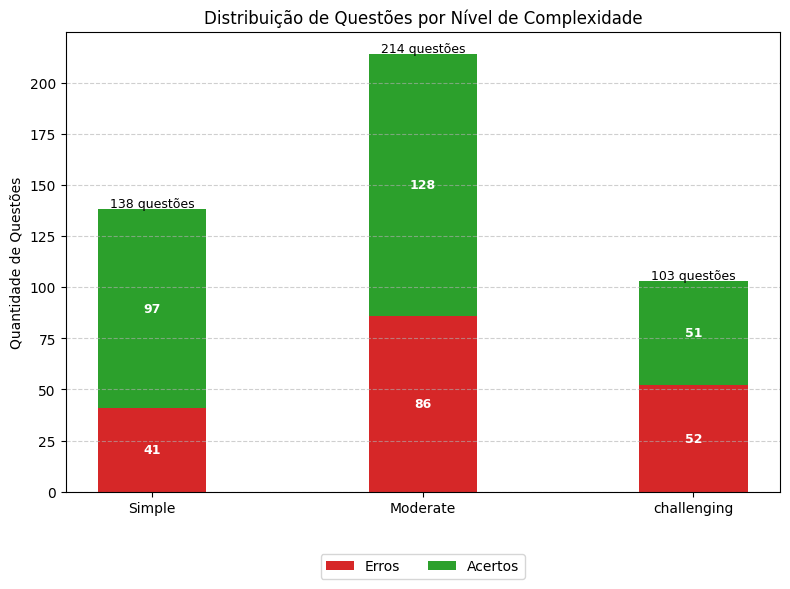

In [12]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np

# Dificuldades e nomes bonitos
dificuldades = ["simple", "moderate", "challenging"]
nomes = ["Simple", "Moderate", "challenging"]

# Inicializa contadores
total_por_dif = {dif: 0 for dif in dificuldades}
acertos_por_dif = {dif: 0 for dif in dificuldades}

# Lê todos os metrics.json
metrics_files = glob.glob("results/**/metrics.json", recursive=True)

for caminho in metrics_files:
    with open(caminho, "r", encoding="utf-8") as f:
        metrics = json.load(f)
    
    for dif in dificuldades:
        stats = metrics.get(f"{dif}_stats", {})
        total_por_dif[dif] += stats.get("count", 0)
        acertos_por_dif[dif] += stats.get("correct_number", 0)

# Calcula erros
erros_por_dif = {dif: total_por_dif[dif] - acertos_por_dif[dif] for dif in dificuldades}

# Dados para plotagem
x = np.arange(len(dificuldades))
acertos = [acertos_por_dif[d] for d in dificuldades]
erros = [erros_por_dif[d] for d in dificuldades]
totais = [total_por_dif[d] for d in dificuldades]
largura = 0.4

# Cores
cor_acertos = "#2ca02c"
cor_erros = "#d62728"

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x, erros, width=largura, color=cor_erros, label="Erros")
plt.bar(x, acertos, width=largura, bottom=erros, color=cor_acertos, label="Acertos")

# Anotações
for i in range(len(dificuldades)):
    plt.text(x[i], erros[i] / 2, f"{erros[i]}", ha='center', va='center', fontsize=9, color='white', weight='bold')
    plt.text(x[i], erros[i] + acertos[i] / 2, f"{acertos[i]}", ha='center', va='center', fontsize=9, color='white', weight='bold')
    plt.text(x[i], erros[i] + acertos[i] + 1, f"{totais[i]} questões", ha='center', fontsize=9, color='black')

# Estilo
plt.xticks(x, nomes)
plt.ylabel("Quantidade de Questões")
plt.title("Distribuição de Questões por Nível de Complexidade")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
plt.tight_layout()
plt.show()


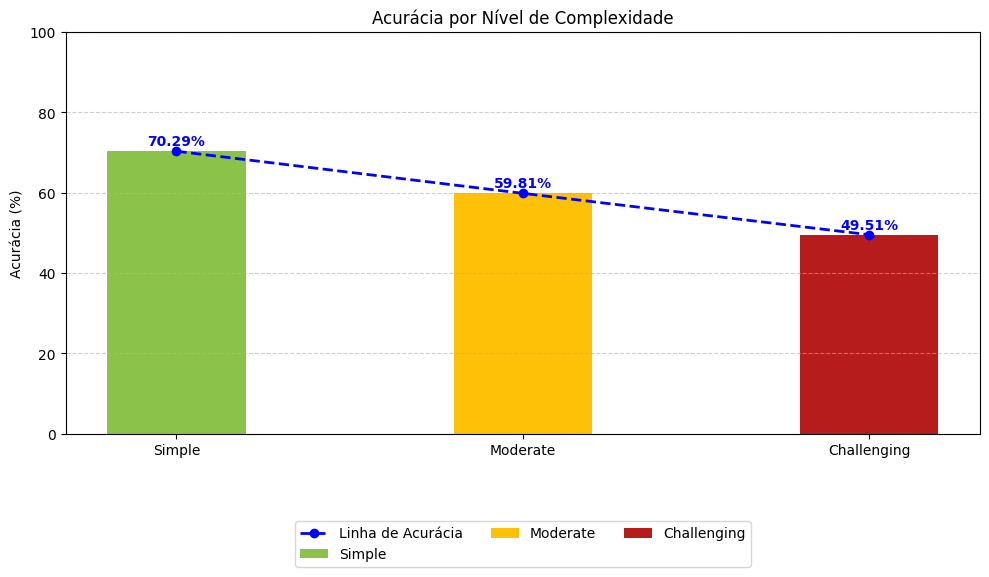

In [ ]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np

# Dificuldades e nomes bonitos
dificuldades = ["simple", "moderate", "challenging"]
nomes = ["Simple", "Moderate", "Challenging"]

# Inicializa contadores
total_por_dif = {dif: 0 for dif in dificuldades}
acertos_por_dif = {dif: 0 for dif in dificuldades}

# Lê todos os metrics.json
metrics_files = glob.glob("results/**/metrics.json", recursive=True)

for caminho in metrics_files:
    with open(caminho, "r", encoding="utf-8") as f:
        metrics = json.load(f)
    
    for dif in dificuldades:
        stats = metrics.get(f"{dif}_stats", {})
        total_por_dif[dif] += stats.get("count", 0)
        acertos_por_dif[dif] += stats.get("correct_number", 0)

# Calcula acurácia por dificuldade
acuracias_dificuldade = {
    dif.capitalize(): (acertos_por_dif[dif] / total_por_dif[dif] * 100 if total_por_dif[dif] > 0 else 0)
    for dif in dificuldades
}

# Plotagem do gráfico de acurácia
# Ordem fixa
dificuldades_plot = ["Simple", "Moderate", "Challenging"]
acuracias = [acuracias_dificuldade[d] for d in dificuldades_plot]
x = np.arange(len(dificuldades_plot))
largura = 0.4

# Cores fixas por dificuldade
cores_dificuldade = {
    "Simple": "#8bc34a",
    "Moderate": "#ffc107",
    "Challenging": "#b71c1c"
}

# Plot
plt.figure(figsize=(10, 6))

# Barras por dificuldade
for i, dif in enumerate(dificuldades_plot):
    plt.bar(x[i], acuracias[i], width=largura, color=cores_dificuldade[dif], label=dif)
    plt.text(x[i], acuracias[i] + 1.5, f"{acuracias[i]:.2f}%", ha='center', fontsize=10, color='blue', weight='bold')

# Linha de acurácia
plt.plot(x, acuracias, color='blue', linestyle='--', marker='o', linewidth=2, label="Linha de Acurácia")

# Estilo
plt.ylim(0, 100)
plt.xticks(x, dificuldades_plot)
plt.ylabel("Acurácia (%)")
plt.title("Acurácia por Nível de Complexidade")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.tight_layout()
plt.show()


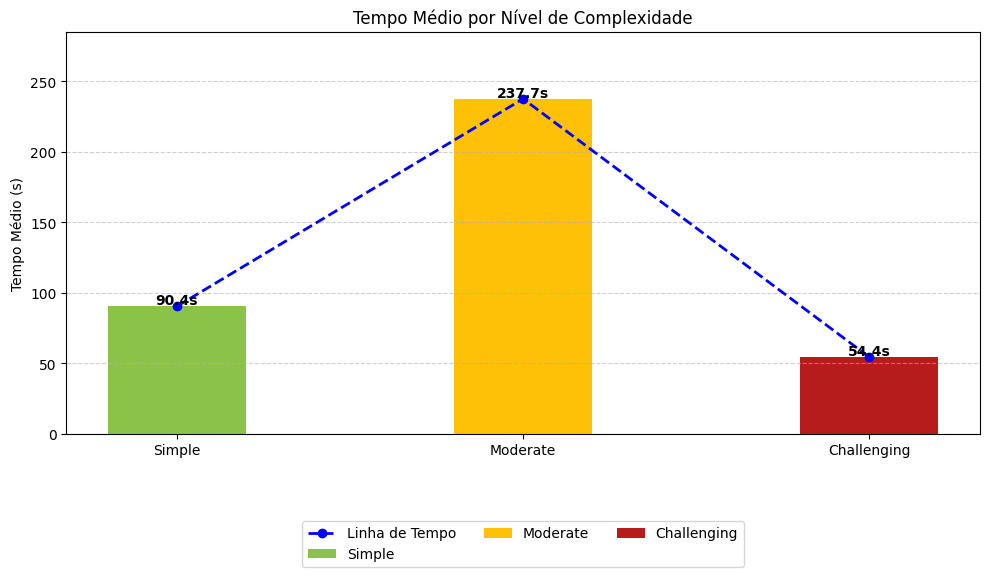

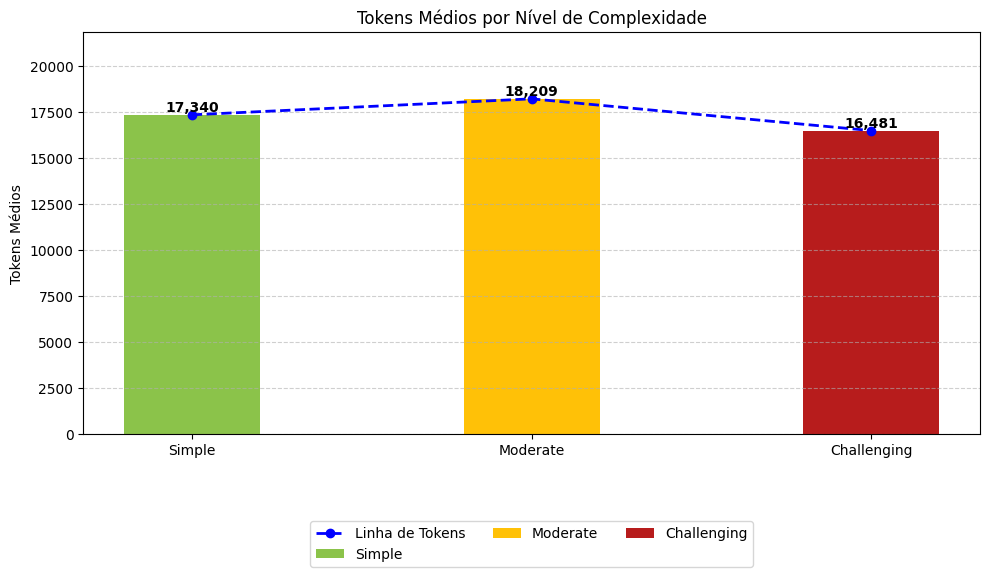

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import json
import glob

# Inicialização
dificuldades_raw = ["simple", "moderate", "challenging"]
dificuldades = ["Simple", "Moderate", "Challenging"]
tempos_totais = {dif: 0.0 for dif in dificuldades_raw}
tokens_totais = {dif: 0 for dif in dificuldades_raw}
contagem_por_dif = {dif: 0 for dif in dificuldades_raw}

# Lê os predictions.json
prediction_files = glob.glob("results/**/predictions.json", recursive=True)

for caminho in prediction_files:
    with open(caminho, "r", encoding="utf-8") as f:
        dados = json.load(f)

    for item in dados:
        dif = item.get("difficulty")
        if dif in dificuldades_raw:
            contagem_por_dif[dif] += 1
            tempos_totais[dif] += item.get("timing", {}).get("total_time", 0.0)
            tokens_totais[dif] += item.get("total_usage", {}).get("total_tokens", 0)

# Converte para formato usado no gráfico (capitalizado)
tempo_medio_por_dificuldade = {
    dif.capitalize(): tempos_totais[dif] / contagem_por_dif[dif] if contagem_por_dif[dif] > 0 else 0
    for dif in dificuldades_raw
}

tokens_medio_por_dificuldade = {
    dif.capitalize(): tokens_totais[dif] / contagem_por_dif[dif] if contagem_por_dif[dif] > 0 else 0
    for dif in dificuldades_raw
}

# Cores consistentes com a acurácia
cores_dificuldade = {
    "Simple": "#8bc34a",       # verde claro
    "Moderate": "#ffc107",     # amarelo ovo
    "Challenging": "#b71c1c"   # vermelho escuro
}

# Ordem
dificuldades = ["Simple", "Moderate", "Challenging"]
x = np.arange(len(dificuldades))
largura = 0.4

# === Gráfico 1: Tempo médio por dificuldade ===
tempos = [tempo_medio_por_dificuldade[d] for d in dificuldades]

plt.figure(figsize=(10, 6))
for i, dif in enumerate(dificuldades):
    plt.bar(x[i], tempos[i], width=largura, color=cores_dificuldade[dif], label=dif)
    plt.text(x[i], tempos[i] + 1.5, f"{tempos[i]:.1f}s", ha='center', fontsize=10, color='black', weight='bold')

plt.plot(x, tempos, color='blue', linestyle='--', marker='o', linewidth=2, label="Linha de Tempo")
plt.ylim(0, max(tempos)*1.2)
plt.xticks(x, dificuldades)
plt.ylabel("Tempo Médio (s)")
plt.title("Tempo Médio por Nível de Complexidade")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.tight_layout()
plt.show()

# === Gráfico 2: Tokens médios por dificuldade ===
tokens = [tokens_medio_por_dificuldade[d] for d in dificuldades]

plt.figure(figsize=(10, 6))
for i, dif in enumerate(dificuldades):
    plt.bar(x[i], tokens[i], width=largura, color=cores_dificuldade[dif], label=dif)
    plt.text(x[i], tokens[i] + 200, f"{tokens[i]:,.0f}", ha='center', fontsize=10, color='black', weight='bold')

plt.plot(x, tokens, color='blue', linestyle='--', marker='o', linewidth=2, label="Linha de Tokens")
plt.ylim(0, max(tokens)*1.2)
plt.xticks(x, dificuldades)
plt.ylabel("Tokens Médios")
plt.title("Tokens Médios por Nível de Complexidade")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.tight_layout()
plt.show()


=== Variabilidade da acurácia por base ===
Desvio padrão: 20.57%
Amplitude (máx - mín): 66.81%


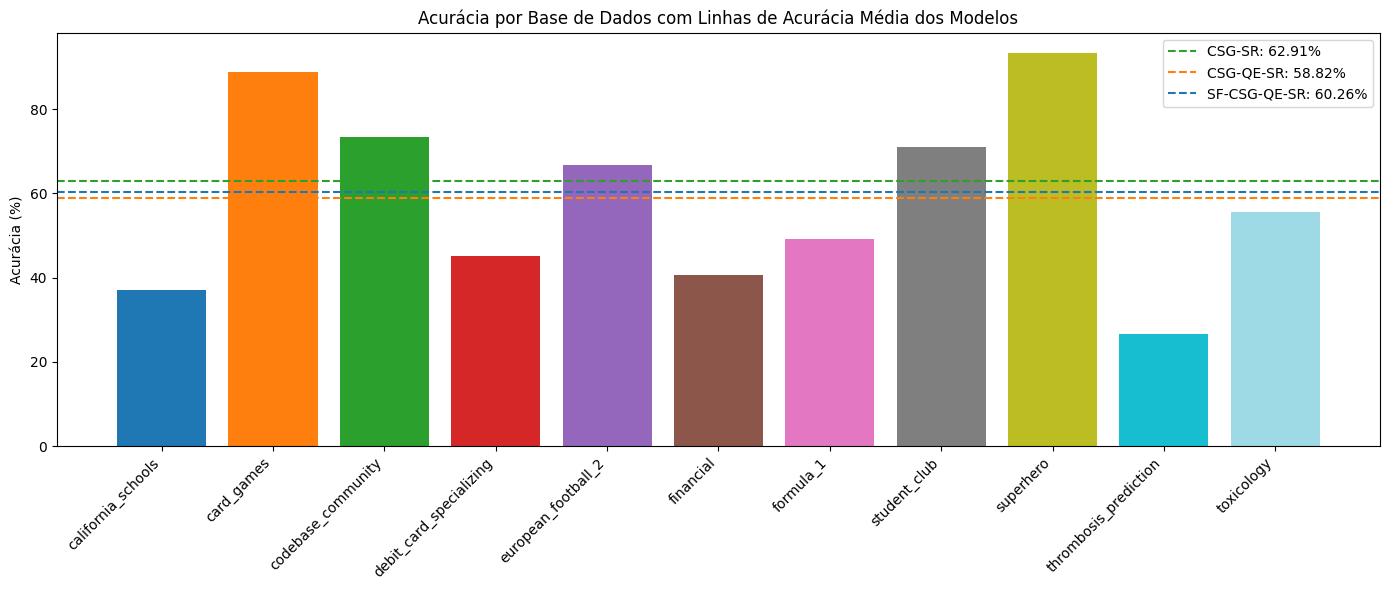

In [23]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Acurácia média dos modelos com cores distintas
linhas_acuracia = {
    "CSG-SR": {"valor": 62.91, "cor": "#2ca02c"},       # verde
    "CSG-QE-SR": {"valor": 58.82, "cor": "#ff7f0e"},    # laranja
    "SF-CSG-QE-SR": {"valor": 60.26, "cor": "#1f77b4"}  # azul
}

# Inicializa estruturas
acertos_por_base = defaultdict(int)
total_por_base = defaultdict(int)

# Lê predictions.json
prediction_files = glob.glob("results/**/predictions.json", recursive=True)

for caminho in prediction_files:
    with open(caminho, "r", encoding="utf-8") as f:
        dados = json.load(f)

    for item in dados:
        db = item.get("db_id")
        resultado = item.get("results", {}).get("exec_res")
        if db and resultado is not None:
            total_por_base[db] += 1
            if resultado == 1:
                acertos_por_base[db] += 1

# Calcula acurácia por base
acuracia_por_base = {}
for db in total_por_base:
    total = total_por_base[db]
    acertos = acertos_por_base[db]
    acuracia = acertos / total * 100 if total > 0 else 0
    acuracia_por_base[db] = acuracia

# Ordena para plotagem
bases = sorted(acuracia_por_base)
valores = [acuracia_por_base[db] for db in bases]

# Variabilidade
desvio_padrao = np.std(valores)
amplitude = max(valores) - min(valores)

print("=== Variabilidade da acurácia por base ===")
print(f"Desvio padrão: {desvio_padrao:.2f}%")
print(f"Amplitude (máx - mín): {amplitude:.2f}%")

# Plot
x = np.arange(len(bases))
colors = plt.cm.tab20(np.linspace(0, 1, len(bases)))  # cores variadas

plt.figure(figsize=(14, 6))
plt.bar(x, valores, color=colors)

# Linhas horizontais coloridas
for nome, dados in linhas_acuracia.items():
    plt.axhline(dados["valor"], linestyle='--', linewidth=1.5, color=dados["cor"], label=f'{nome}: {dados["valor"]:.2f}%')

# Estética
plt.xticks(x, bases, rotation=45, ha="right")
plt.ylabel("Acurácia (%)")
plt.title("Acurácia por Base de Dados com Linhas de Acurácia Média dos Modelos")
plt.legend()
plt.tight_layout()
plt.show()


